In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn import preprocessing
import random
from sklearn.model_selection import train_test_split

In [2]:
test=pd.read_csv("../data/ee660_hw2/H2_data_Test.csv")
train=pd.read_csv("../data/ee660_hw2/H2_data_Train.csv")

In [3]:
Xtrain=train.values[:, :7]
Ytrain=train.values[:,-1]
Xtest=test.values[:, :7]
Ytest=test.values[:, -1]
Xtrain

array([[-49, -52, -46, ..., -60, -79, -80],
       [-49, -53, -50, ..., -67, -78, -88],
       [-50, -52, -51, ..., -67, -77, -88],
       ...,
       [-46, -52, -51, ..., -60, -80, -76],
       [-61, -56, -67, ..., -69, -82, -87],
       [-61, -54, -52, ..., -49, -85, -91]], dtype=int64)

In [4]:
le = preprocessing.LabelEncoder()
le.fit(Ytest)
le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
Ytrain_enc=le.transform(Ytrain)
Ytest_enc=le.transform(Ytest)
le_dict

{1: 0, 2: 1, 3: 2, 4: 3}

In [5]:
lab_0=0
lab_1=0
lab_2=0
lab_3=0
for lab in Ytrain_enc:
    if lab==0:
        lab_0=lab_0+1
    elif lab==1:
        lab_1=lab_1+1
    elif lab==2:
        lab_2=lab_2+1
    elif lab==3:
        lab_3=lab_3+1

In [6]:
def cal_frequency(lab_count):
    fre=lab_count/1000
    return fre

In [7]:
lab_0_fre=cal_frequency(lab_0)
lab_1_fre=cal_frequency(lab_1)
lab_2_fre=cal_frequency(lab_2)
lab_3_fre=cal_frequency(lab_3)
prob_arr=[lab_0_fre,lab_1_fre,lab_2_fre,lab_3_fre]
prob_arr

[0.375, 0.375, 0.375, 0.375]

In [8]:
def classification_error(Ytrue,Ypred):
    misclasf=0
    for i in range(len(Ytrue)):
        if Ytrue[i]!=Ypred[i]:
            misclasf=misclasf+1
    misclasf_err=misclasf/len(Ytrue)
    return misclasf_err

In [9]:
def classifier1(seed_val,trainY,testY,target_label,pro):
    random.seed(seed_val)
    train_pred=random.choices(target_label, weights=pro, k=len(trainY))
    test_pred=random.choices(target_label, weights=pro, k=len(testY))
    train_error=classification_error(trainY,train_pred)
    test_error=classification_error(testY,test_pred)
    return train_error,test_error

In [10]:
seed_value=[1,10,100,500,1000,2500,5000,7500,10000,50000]
train_err_clf1=[]
test_err_clf1=[]
for value in seed_value:
    train_err,test_err=classifier1(value,Ytrain_enc,Ytest_enc,[0,1,2,3],
                                   prob_arr)
    train_err_clf1.append(train_err)
    test_err_clf1.append(test_err)
    mean_train_error_clf1=np.mean(train_err_clf1)
    std_train_error_clf1=np.std(train_err_clf1)
    mean_test_error_clf1=np.mean(test_err_clf1)
    std_test_error_clf1=np.std(test_err_clf1)
print("Mean training error for trivial CLF 1:",round(mean_train_error_clf1,4))
print("STD for trivial CLF 1 :",round(std_train_error_clf1,2))
print("Mean test error for trivial CLF 1:",round(mean_test_error_clf1,4))
print("STD for trivial for trivial CLF 1 :",round(std_test_error_clf1,2))

Mean training error for trivial CLF 1: 0.7534
STD for trivial CLF 1 : 0.01
Mean test error for trivial CLF 1: 0.7508
STD for trivial for trivial CLF 1 : 0.02


In [12]:
def classifier2_populated(trainY,testY,pro):
    label_high_freq=np.argmax(pro)
    train_pred=[label_high_freq]*len(trainY)
    test_pred=[label_high_freq]*len(testY)
    train_error=classification_error(trainY,train_pred)
    test_error=classification_error(testY,test_pred)
    return train_error,test_error

In [13]:
train_err_clf2,test_err_clf2=classifier2_populated(Ytrain_enc,Ytest_enc,
                                                   prob_arr)
print("Training error for trivial CLF 2 ={:.2f}  ".format(train_err_clf2))
print("Test error for trivial CLF 2 = {:.2f} ".format(test_err_clf2))

Training error for trivial CLF 2 =0.75  
Test error for trivial CLF 2 = 0.75 


## random forest

In [14]:
def classifier3_randomforest(trainX,trainY,testX,testY,bag_size,n_trees,
                             depth,features,random_val):
    testsize_bag=1-bag_size
    Xtrain_bag, Xtest_bag, Ytrain_bag, Ytest_bag =train_test_split(trainX,
                    trainY, test_size=testsize_bag,random_state=random_val)
    clf=RandomForestClassifier(n_estimators=n_trees,criterion='gini',
                                max_depth=depth, 
                               max_features=features,bootstrap=True)
    clf.fit(Xtrain_bag,Ytrain_bag)
    train_pred=clf.predict(Xtrain_bag)
    test_pred=clf.predict(testX)
    train_error=classification_error(Ytrain_bag,train_pred)
    test_error=classification_error(testY,test_pred)
    return train_error,test_error

##  Q2: b) i) :

In [16]:
#n_estimators = 1 to B, step size 5, B=101.
estimators=np.arange(1,101,5)
bag_random_state=np.linspace(10,1000,10,dtype=int)
mean_train_err_randomforest=[]
mean_test_err_randomforest=[]
std_train_err_randomforest=[]
std_test_err_randomforest=[]
for b in estimators:
    train_error_array=[]
    test_error_array=[]
    for s in bag_random_state:
        train_err,test_err=classifier3_randomforest(Xtrain,Ytrain_enc,
                            Xtest,Ytest_enc,0.8,b,5,2,s)
        train_error_array.append(train_err)
        test_error_array.append(test_err)
    mean_train_error=np.mean(train_error_array)
    std_train_error=np.std(train_error_array)
    mean_test_error=np.mean(test_error_array)
    std_test_error=np.std(test_error_array)
    mean_train_err_randomforest.append(mean_train_error)
    std_train_err_randomforest.append(std_train_error)
    mean_test_err_randomforest.append(mean_test_error)
    std_test_err_randomforest.append(std_test_error)

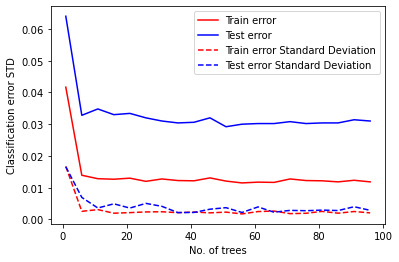

Minimun test error rate = 0.029200000000000004 /0.003709447398198281 


In [22]:
plt.figure(1)
plt.plot(estimators,mean_train_err_randomforest,color='red',label='Train error')
plt.plot(estimators,mean_test_err_randomforest,color='blue',label='Test error')
plt.plot(estimators,std_train_err_randomforest,'r--',
         label='Train error Standard Deviation')
plt.plot(estimators,std_test_err_randomforest,'b--',
         label='Test error Standard Deviation')
plt.xlabel('No. of trees')
plt.ylabel('Classification error STD')
plt.legend()
plt.show()
best_err_idx=np.argmin(mean_test_err_randomforest)
print("Minimun test error rate = {} /{} ".
      format(mean_test_err_randomforest[best_err_idx],
             std_test_err_randomforest[best_err_idx]))


##  Q2: b) i) :


In [22]:
#setting B=21
estimators=np.arange(1,21,1)
bag_random_state=np.linspace(10,1000,10,dtype=int)
mean_train_err_randomforest=[]
mean_test_err_randomforest=[]
std_train_err_randomforest=[]
std_test_err_randomforest=[]
for b in estimators:
    train_error_array=[]
    test_error_array=[]
    for s in bag_random_state:
        train_err,test_err=classifier3_randomforest(Xtrain,Ytrain_enc,
                                    Xtest,Ytest_enc,0.8,b,5,2,s)
        train_error_array.append(train_err)
        test_error_array.append(test_err)
    mean_train_error=np.mean(train_error_array)
    std_train_error=np.std(train_error_array)
    mean_test_error=np.mean(test_error_array)
    std_test_error=np.std(test_error_array)
    mean_train_err_randomforest.append(mean_train_error)
    std_train_err_randomforest.append(std_train_error)
    mean_test_err_randomforest.append(mean_test_error)
    std_test_err_randomforest.append(std_test_error)

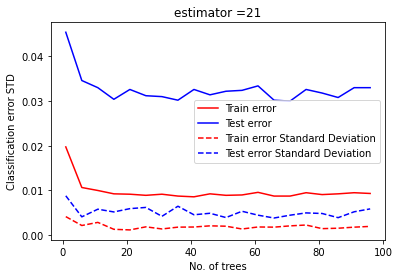

Minimun test error rate = 0.030000000000000006 / 0.00447213595499958 


In [35]:
plt.figure(2)
plt.plot(estimators,mean_train_err_randomforest,color='red',label='Train error')
plt.plot(estimators,mean_test_err_randomforest,color='blue',label='Test error')
plt.plot(estimators,std_train_err_randomforest,'r--',
         label='Train error Standard Deviation')
plt.plot(estimators,std_test_err_randomforest,'b--',
         label='Test error Standard Deviation')
plt.xlabel('No. of trees')
plt.ylabel('Classification error STD')
plt.title("estimator =21")
plt.legend()
plt.show()
best_err_idx=np.argmin(mean_test_err_randomforest)
print("Minimun test error rate = {} / {} "
    .format(mean_test_err_randomforest[best_err_idx],
            std_test_err_randomforest[best_err_idx]))

##  Q2:b:ii) Now set max_features=[3,4] and try again. Plot the results and answer the questions as described in (b)(i) (2 plots, each with 4 “curves” for (b)(ii)).   compare the curves for max_features = 2, 3, and 4.

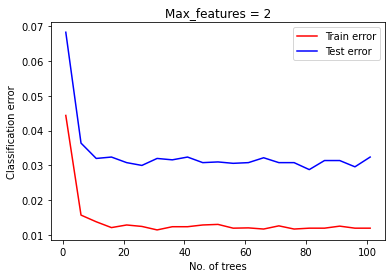

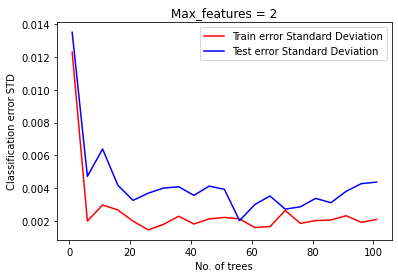

Minimun test error rate for Max_features:2 == 0.028800000000000003 /0.003370459909270544 


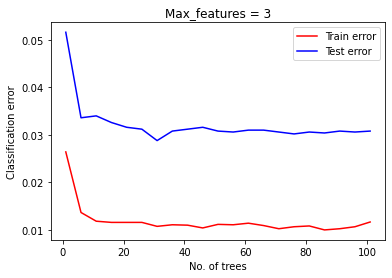

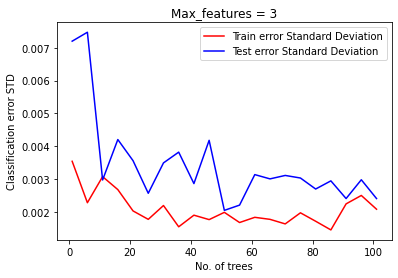

Minimun test error rate for Max_features:3 == 0.028800000000000003 /0.003487119154832539 


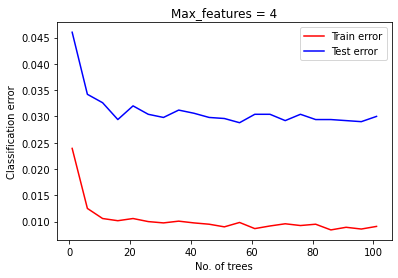

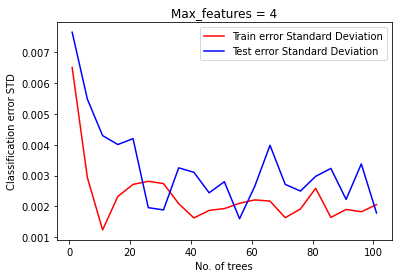

Minimun test error rate for Max_features:4 == 0.028800000000000003 /0.0016 


In [25]:
max_features_=[2,3,4]
estimators=np.arange(1,105,5)
bag_random_state=np.linspace(10,1000,10,dtype=int)
for feat in max_features_:
    mean_train_err_randomforest=[]
    mean_test_err_randomforest=[]
    std_train_err_randomforest=[]
    std_test_err_randomforest=[]
    for b in estimators:
        train_error_array=[]
        test_error_array=[]
        for s in bag_random_state:
            train_err,test_err=classifier3_randomforest(Xtrain,Ytrain_enc,
                                    Xtest,Ytest_enc,0.8,b,5,feat,s)
            train_error_array.append(train_err)
            test_error_array.append(test_err)
        mean_train_error=np.mean(train_error_array)
        std_train_error=np.std(train_error_array)
        mean_test_error=np.mean(test_error_array)
        std_test_error=np.std(test_error_array)
        mean_train_err_randomforest.append(mean_train_error)
        std_train_err_randomforest.append(std_train_error)
        mean_test_err_randomforest.append(mean_test_error)
        std_test_err_randomforest.append(std_test_error)
    plt.figure()
    plt.plot(estimators,mean_train_err_randomforest,color='red',
             label='Train error')
    plt.plot(estimators,mean_test_err_randomforest,color='blue',
             label='Test error')
    plt.xlabel('No. of trees')
    plt.ylabel('Classification error')
    plt.legend()
    plt.title('Max_features = {}'.format(feat))
    plt.figure()
    plt.plot(estimators,std_train_err_randomforest,color='red',
             label='Train error Standard Deviation')
    plt.plot(estimators,std_test_err_randomforest,color='blue',
             label='Test error Standard Deviation')
    plt.xlabel('No. of trees')
    plt.ylabel('Classification error STD')
    plt.legend()
    plt.title('Max_features = {}'.format(feat))
    plt.show()
    best_err_idx=np.argmin(mean_test_err_randomforest)
    print("Minimun test error rate for Max_features:{} == {} /{} "
          .format(feat,mean_test_err_randomforest[best_err_idx],
                  std_test_err_randomforest[best_err_idx]))

## Q2 B(iii) Finally try max_features = 7

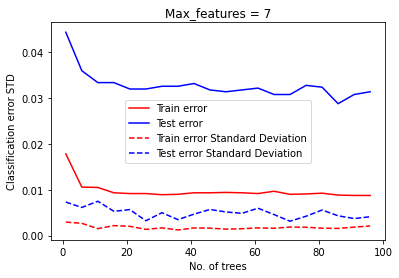

Minimun test error rate for Max_features:7 == 0.028800000000000003 / 0.004308131845707603 


In [36]:
max_features_=[7]
estimators=np.arange(1,101,5)
bag_random_state=np.linspace(10,1000,10,dtype=int)
for feat in max_features_:
    mean_train_err_randomforest=[]
    mean_test_err_randomforest=[]
    std_train_err_randomforest=[]
    std_test_err_randomforest=[]
    for b in estimators:
        train_error_array=[]
        test_error_array=[]
        for s in bag_random_state:
            train_err,test_err=classifier3_randomforest(Xtrain,
                            Ytrain_enc,Xtest,Ytest_enc,0.8,b,5,feat,s)
            train_error_array.append(train_err)
            test_error_array.append(test_err)
        mean_train_error=np.mean(train_error_array)
        std_train_error=np.std(train_error_array)
        mean_test_error=np.mean(test_error_array)
        std_test_error=np.std(test_error_array)
        mean_train_err_randomforest.append(mean_train_error)
        std_train_err_randomforest.append(std_train_error)
        mean_test_err_randomforest.append(mean_test_error)
        std_test_err_randomforest.append(std_test_error)
    plt.figure(3)
    plt.plot(estimators,mean_train_err_randomforest,color='red',
             label='Train error')
    plt.plot(estimators,mean_test_err_randomforest,color='blue',
             label='Test error')
    plt.plot(estimators,std_train_err_randomforest,'r--',
             label='Train error Standard Deviation')
    plt.plot(estimators,std_test_err_randomforest,'b--',
             label='Test error Standard Deviation')
    plt.xlabel('No. of trees')
    plt.ylabel('Classification error STD')
    plt.legend()
    plt.title('Max_features = {}'.format(feat))
    plt.show()
    best_err_idx=np.argmin(mean_test_err_randomforest)
    print("Minimun test error rate for Max_features:{} == {} / {} "
          .format(feat,mean_test_err_randomforest[best_err_idx], 
                  std_test_err_randomforest[best_err_idx]))


## Q2  b(iv) starting from max_depth = 2 to 25 with step 

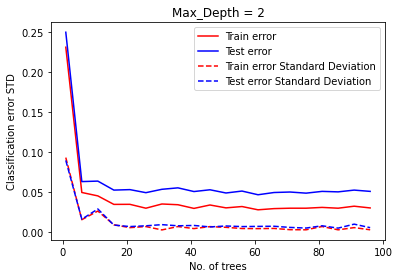

Minimun test error rate for Max_Depth:2 == 0.047 / 0.007602631123499286 


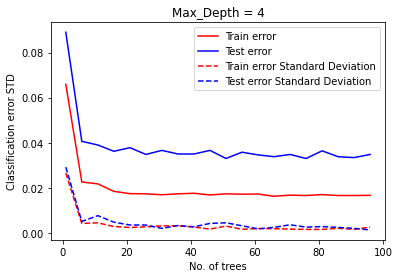

Minimun test error rate for Max_Depth:4 == 0.03300000000000001 / 0.004494441010848847 


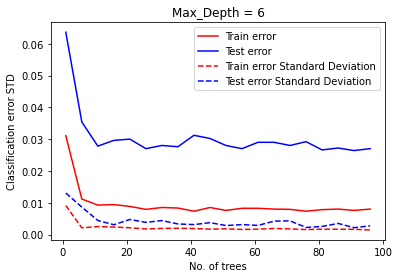

Minimun test error rate for Max_Depth:6 == 0.026399999999999996 / 0.0021540659228538013 


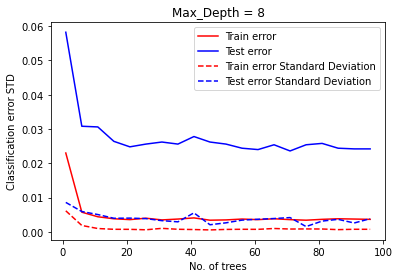

Minimun test error rate for Max_Depth:8 == 0.0236 / 0.00417612260356422 


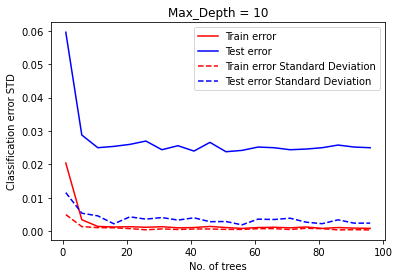

Minimun test error rate for Max_Depth:10 == 0.023799999999999998 / 0.002891366458960192 


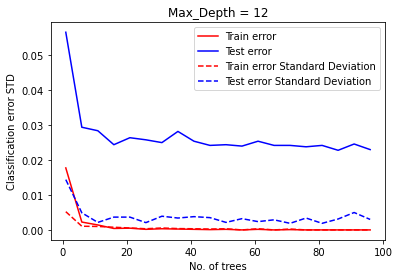

Minimun test error rate for Max_Depth:12 == 0.022799999999999997 / 0.0031240998703626617 


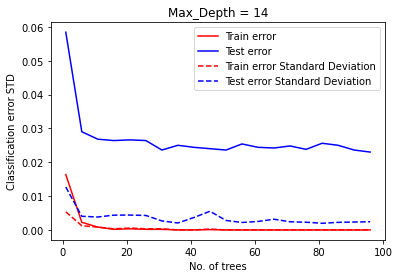

Minimun test error rate for Max_Depth:14 == 0.023 / 0.002408318915758459 


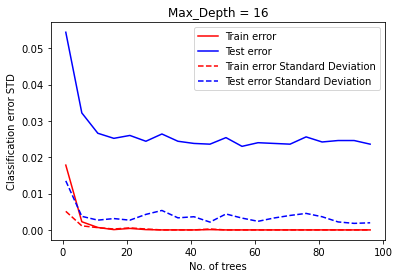

Minimun test error rate for Max_Depth:16 == 0.023 / 0.003255764119219941 


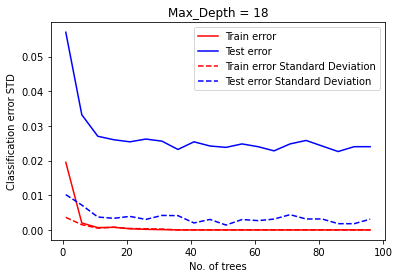

Minimun test error rate for Max_Depth:18 == 0.0226 / 0.0018000000000000002 


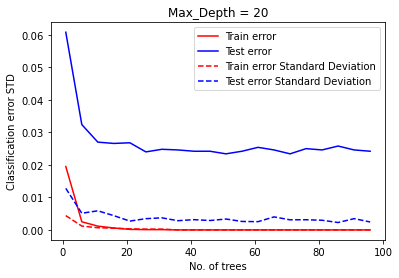

Minimun test error rate for Max_Depth:20 == 0.023399999999999997 / 0.0033526109228480417 


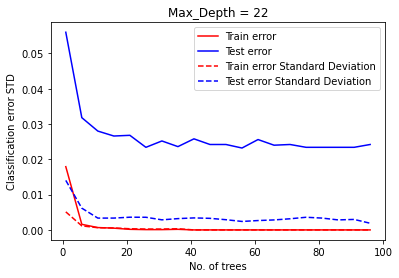

Minimun test error rate for Max_Depth:22 == 0.0232 / 0.0024 


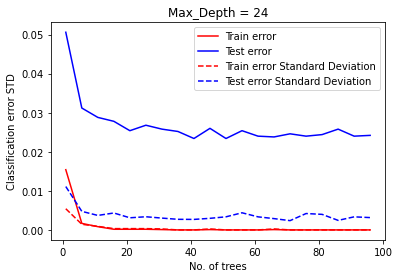

Minimun test error rate for Max_Depth:24 == 0.023399999999999997 / 0.0026907248094147425 


In [38]:
max_depth_=np.arange(2,25,2)
estimators=np.arange(1,101,5)
bag_random_state=np.linspace(10,1000,10,dtype=int)
for deep in max_depth_:
    mean_train_err_randomforest=[]
    mean_test_err_randomforest=[]
    std_train_err_randomforest=[]
    std_test_err_randomforest=[]
    for b in estimators:
        train_error_array=[]
        test_error_array=[]
        for s in bag_random_state:
            train_err,test_err=classifier3_randomforest(Xtrain,Ytrain_enc,
                                        Xtest,Ytest_enc,0.8,b,deep,2,s)
            train_error_array.append(train_err)
            test_error_array.append(test_err)
        mean_train_error=np.mean(train_error_array)
        std_train_error=np.std(train_error_array)
        mean_test_error=np.mean(test_error_array)
        std_test_error=np.std(test_error_array)
        mean_train_err_randomforest.append(mean_train_error)
        std_train_err_randomforest.append(std_train_error)
        mean_test_err_randomforest.append(mean_test_error)
        std_test_err_randomforest.append(std_test_error)
    plt.figure()
    plt.plot(estimators,mean_train_err_randomforest,color='red',
             label='Train error')
    plt.plot(estimators,mean_test_err_randomforest,color='blue',
             label='Test error')
    plt.plot(estimators,std_train_err_randomforest,'r--',
             label='Train error Standard Deviation')
    plt.plot(estimators,std_test_err_randomforest,'b--',
             label='Test error Standard Deviation')
    plt.xlabel('No. of trees')
    plt.ylabel('Classification error STD')
    plt.legend()
    plt.title('Max_Depth = {}'.format(deep))
    plt.show()
    best_err_idx=np.argmin(mean_test_err_randomforest)
    print("Minimun test error rate for Max_Depth:{} == {} / {} "
          .format(deep,mean_test_err_randomforest[best_err_idx],
                  std_test_err_randomforest[best_err_idx]))

## Q2  b(v) choose a best setting.

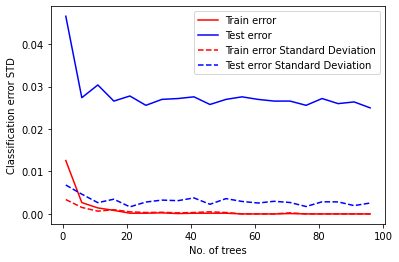

Minimun test error rate = 0.025 / 0.002569046515733026 


In [43]:
estimators=np.arange(1,101,5)
bag_random_state=np.linspace(10,1000,10,dtype=int)
mean_train_err_randomforest=[]
mean_test_err_randomforest=[]
std_train_err_randomforest=[]
std_test_err_randomforest=[]
for b in estimators:
    train_error_array=[]
    test_error_array=[]
    for s in bag_random_state:
        train_err,test_err=classifier3_randomforest(Xtrain,Ytrain_enc,
                                                Xtest,Ytest_enc,0.8,b,18,4,s)
        train_error_array.append(train_err)
        test_error_array.append(test_err)
    mean_train_error=np.mean(train_error_array)
    std_train_error=np.std(train_error_array)
    mean_test_error=np.mean(test_error_array)
    std_test_error=np.std(test_error_array)
    mean_train_err_randomforest.append(mean_train_error)
    std_train_err_randomforest.append(std_train_error)
    mean_test_err_randomforest.append(mean_test_error)
    std_test_err_randomforest.append(std_test_error)
plt.figure(3)
plt.plot(estimators,mean_train_err_randomforest,color='red',label='Train error')
plt.plot(estimators,mean_test_err_randomforest,color='blue',label='Test error')
plt.plot(estimators,std_train_err_randomforest,'r--',
         label='Train error Standard Deviation')
plt.plot(estimators,std_test_err_randomforest,'b--',
         label='Test error Standard Deviation')
plt.xlabel('No. of trees')
plt.ylabel('Classification error STD')
plt.legend()
plt.show()
best_err_idx=np.argmin(mean_test_err_randomforest)
print("Minimun test error rate = {} / {} "
      .format(mean_test_err_randomforest[best_err_idx],
              std_test_err_randomforest[best_err_idx]))